In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, r"/mnt/c/Users/Trez/Desktop/tudat-bundle/tudatpy/")

# Improved state estimation with MPC
Copyright (c) 2010-2024, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example extends the previous [Initial state estimation with Minor Planet Center Observations](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/estimation_with_mpc.html). In an attempt to improve the results from the previous example, we introduce and compare the effects of including satellite data, star catalog corrections, observation weighting and more expansive acceleration models. It essential to be familiar with the previous example as many concepts will be reused here without explanation. 

As in the previous example we will estimate the initial state of [433 Eros](https://en.wikipedia.org/wiki/433_Eros). In addition to observation data from MPC and metadata from SBDB, we now also use ephemeris data from JPL Horizons to retrieve position data for observing space telescopes, additional perturbing bodies and as a method of comparison. This is accomplished using Tudat's HorizonsQuery Interface.

## Import statements

In [3]:
# Tudat imports for propagation and estimation
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.constants import GRAVITATIONAL_CONSTANT
from tudatpy.astro.frame_conversion import inertial_to_rsw_rotation_matrix


# import MPC, SBDB and Horizons interface
from tudatpy.data.mpc import BatchMPC
from tudatpy.data.horizons import HorizonsQuery
from tudatpy.data.sbdb import SBDBquery


# other useful modules
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# SPICE KERNELS
spice.load_standard_kernels()

## Preparing the environment and observations

### Setting the input constants
Let's setup some constants that are used throughout the tutorial. The MPC code for Eros is 433. We also set a start and end date for our observations, the number of iterations for our estimation, a timestep for our integrator and a 1 month buffer to avoid interpolation errors in our analysis.

We use a spice kernel to get a guess for our initial state and to check our estimation afterwards. The default spice kernel `codes_300ast_20100725.bsp` contains many popular asteroids, however they are not all identified by name (433 Eros is `"Eros"` but 16 Psyche is `"2000016"` etc.). To ensure this example works dynamically, for any single MPC code as input we use the SDBD to retrieve the name and SPK-ID used for the spice kernel.

For our frame origin we use the Solar System Barycentre. The data from MPC is presented in the J2000 reference frame, currently BatchMPC does not support conversion to other reference frames and as such we match it in our environment. 

For this extended example, a longer observation period of 9 years is used.

Direct inputs:

In [4]:
target_mpc_code = "433"

observations_start = datetime.datetime(2015, 1, 1)
observations_end = datetime.datetime(2024, 1, 1)

# number of iterations for our estimation
number_of_pod_iterations = 6

# timestep of 24 hours for our estimation
timestep_global = 24 * 3600

# 2 month time buffer used to avoid interpolation errors:
time_buffer = 2 * 31 * 86400

# define the frame origin and orientation.
global_frame_origin = "Sun"
global_frame_orientation = "J2000"

Derived inputs:

In [5]:
target_sbdb = SBDBquery(target_mpc_code)

mpc_codes = [target_mpc_code]  # the BatchMPC interface requires a list.
target_spkid = target_sbdb.codes_300_spkid  # the ID used by the
target_name = target_sbdb.shortname  # the ID used by the

print(f"SPK ID for {target_name} is: {target_spkid}")

SPK ID for 433 Eros is: Eros


### Combinations and additional body setup
There are various ways to change our estimation. We can create a system of setups to compare those various options and to facilitate comparison. Throughout the example, the following options are considered:
- [`accel_levels`] Different acceleration settings, for this example, 3 options are created in increasing order of realism
    - LVL 1 - Only point-mass gravity for the sun and the 8 mayor planets as well as Schwarzschild relativistic correction for the sun.
    - LVL 2 - LVL 1 + point-mass gravity for the mayor moons of Jupiter, Saturn, Earth and Mars.
    - LVL 3 - LVL 2 + SHG for the Earth and point-mass gravity for Triton, Titania, Pluto, the mayor Near Earth Asteroids (NEA) and largest Main Body Asteroids (MBA). These additional bodies are retrieved through the JPL Horizons interface.
- [`use_sat_data`] Observations by space telescope WISE
- [`use_catalog_cor`] Star catalog corrections as described in "Star catalog position and proper motion corrections in asteroid astrometry II: The Gaia era" by Eggl et al.
- [`use_weighting`] Estimation weights as described in "Statistical analysis of astrometric errors for the most productive asteroid surveys" by Veres et al.

A function, `perform_estimation`, is be created below which will perform the estimation based on these settings. The settings are described by a series of lists below, with a list of setup names to describe them.

The acceleration model is expected to have the most effect on the simulation. For the first round of comparison, only the acceleration models will be changed with the remainder all set to False. Three setups are constructed below. We also define constants to later set up satellite data.

In [6]:
setup_names = ["LVL1 Accelerations", "LVL2 Accelerations", "LVL3 Accelerations"]

accel_levels = [1, 2, 3]
use_sat_data = [False, False, False]
use_catalog_cor = [False, False, False]
use_weighting = [False, False, False]

satellites_names = ["WISE"]
satellites_MPC_codes = ["C51"] # C51 is the observatory code MPC uses for WISE
satellites_Horizons_codes = ["-163"]  # -163 is the query ID for WISE in Horizons see explanation below.

# satellites_names = ["WISE", "TESS"]
# satellites_MPC_codes = ["C51", "C57"]
# satellites_Horizons_codes = ["-163", "-95"]

# satellites_names = ["TESS"]
# satellites_MPC_codes = ["C57"]
# satellites_Horizons_codes = ["-95"]

For LVL3 accelerations, the point-mass gravitational acceleration of Pluto, Triton and Titania are added using JPL Horizons. Horizons only provides an ephemeris, the masses are retrieved and added manually. Note that JPL Horizons has a unique querying scheme in which Pluto is best accessed using the ID 999. The API documentation for the `HorizonsQuery()` class provides an extensive but not exhaustive explanation of these IDs. For now it is sufficient to understand that mayor bodies such as Earth are denoted `399` (3rd mayor body), Asteroids/Minor bodies are denoted with a semicolon like `433;` for Eros (MPC code + ;), and satellites are denote with a minus sign like `-163` for WISE.

JPL Horizons will also be used to retrieve the ephemeris for mayor NEA and MBA. Again their masses will be added through other means, in this case we use [SiMDA](https://astro.kretlow.de/simda/), which is an archive of published mass and diameter estimates for minor bodies. 

All NEAs from the archive are retrieved, as well as all MBA with a mass greater than 1e20 kg. Consider altering this filter to see the effects.

In [7]:
lvl3_extra_bodies = ["999", "Triton", "Titania"] # here 999 is Pluto in JPL Horizons
lvl3_extra_bodies_masses = [1.3025e22, 2.1389e22, 3.4550e21]

In [8]:
file = "SiMDA_240512.csv"

min_asteroid_mass = 1e20 # kg
target_int = int(target_mpc_code)

simda = (
    pd.read_csv(file)
    .iloc[18:] # the first 18 rows contain comets, which are omitted
    .assign(NUM=lambda x: np.int32(x.NUM))
    .query("DYN == 'NEA' | (DYN == 'MBA' & MASS > @min_asteroid_mass)") # filter relevant bodies
    .query("NUM != @target_int") # remove 433 Eros, which is also a NEA
    .query("NUM != [1, 4]") # remove Ceres and Vesta which are retrieved through spice kernels
    .loc[:, ["NUM", "DESIGNATION", "DIAM", "DYN", "MASS"]]
)

lvl3_asteroids = simda.NUM.to_list()
lvl3_asteroids_masses = simda.MASS.to_list()

print(f"Number of additional bodies from SiMDA: {len(simda)}")

simda

Number of additional bodies from SiMDA: 16


,NUM,DESIGNATION,DIAM,DYN,MASS
19,2,Pallas,520.8,MBA,2.050000e+20
384,1036,Ganymed,35.7,NEA,6.580000e+16
395,3671,Dionysus,0.9,NEA,8.380000e+11
398,5381,Sekhmet,1.0,NEA,1.040000e+12
399,25143,Itokawa,0.3,NEA,3.500000e+10
401,35107,1991 VH,1.1,NEA,1.400000e+12
407,65803,Didymos,0.8,NEA,5.240000e+11
408,66063,1998 RO1,0.7,NEA,3.600000e+11
409,66391,1999 KW4,1.3,NEA,2.350000e+12
418,136617,1994 CC,0.6,NEA,2.590000e+11


### Retrieving the observations
As in the previous example, we retrieve observation data using BatchMPC and the initial position using spice. 

In the previous example, a random offset was added to the position and velocity of the initial position. To enable better comparison, this random offset has been omitted for this example:


In [9]:
batch = BatchMPC()
batch.get_observations(mpc_codes)
batch.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
)

# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch.epoch_start
epoch_end_nobuffer = batch.epoch_end

epoch_start_buffer = epoch_start_nobuffer - time_buffer
epoch_end_buffer = epoch_end_nobuffer + time_buffer

initial_guess = spice.get_body_cartesian_state_at_epoch(
    target_spkid,
    global_frame_origin,
    global_frame_orientation,
    "NONE",
    epoch_start_buffer,
)

print("Summary of space telescopes in batch:")
print(batch.observatories_table(only_space_telescopes=True))

Summary of space telescopes in batch:
     Code                                    Name   count
270   275  Non-geocentric Occultation Observation     2.0
1226  C51                                    WISE   155.0
1232  C57                                    TESS  1620.0
1234  C59                              Yangwang-1     2.0


### Retrieving satellite and astroid ephemerides from JPL Horizons
Below we retrieve and store satellite and asteroid ephemerides from JPL Horizons. The HorizonsQuery class included with Tudat's data module provides quick access to ephemeris data for many objects in our solar system. For this example, we provide a start and end date based on the buffered first and last observation dates. We then request the state of the target object at every timestep, centered at our global frame origin and with our global frame orientation. The `.create_ephemeris_tabulated()` method then creates an ephemeris in Tudat format which is then stored for later use.

Tudat uses interpolation to generate an ephemeris model from the tabulated positions and velocities retrieved from JPL Horizons. To speed up the process, we increase the timestep to 100 hours. For the satellites we keep the original timestep as their fast dynamics (Geocentric orbits), would yield inaccurate interpolations.

In [10]:
timestep_horizons = timestep_global * 5

# Ephemeris for satellite(s)
sat_ephemeris = {}
for code, name in zip(satellites_Horizons_codes, satellites_names):
    query = HorizonsQuery(
        query_id=code,
        location=f"@{global_frame_origin}",
        epoch_start=epoch_start_buffer,
        epoch_end=epoch_end_buffer,
        epoch_step=f"{int(timestep_global/60)}m", # Horizons does not permit a stepsize in seconds
        extended_query=True, # extended query allows for more data to be retrieved.
    )

    sat_ephemeris[name] = query.create_ephemeris_tabulated(
        frame_origin=global_frame_origin,
        frame_orientation=global_frame_orientation,
    )

# Ephemeris for asteroids
ast_ephemeris = {}
for code in lvl3_asteroids:
    query = HorizonsQuery(
        query_id=f"{code};",
        location=f"@{global_frame_origin}",
        epoch_start=epoch_start_buffer - 12 * 31 * 86400,
        epoch_end=epoch_end_buffer + 12 * 31 * 86400,
        epoch_step=f"{int(timestep_horizons/60)}m",
        extended_query=True,
    )

    ast_ephemeris[code] = query.create_ephemeris_tabulated(
        frame_origin=global_frame_origin,
        frame_orientation=global_frame_orientation,
    )

# Ephemeris for Pluto, Triton and Titania
other_ephemeris = {}
for code in lvl3_extra_bodies:
    query = HorizonsQuery(
        query_id=f"{code}",
        location=f"@{global_frame_origin}",
        epoch_start=epoch_start_buffer - 12 * 31 * 86400,
        epoch_end=epoch_end_buffer + 12 * 31 * 86400,
        epoch_step=f"{int(timestep_horizons/60)}m",
        extended_query=True,
    )

    other_ephemeris[code] = query.create_ephemeris_tabulated(
        frame_origin=global_frame_origin,
        frame_orientation=global_frame_orientation,
    )

### Set up the environment
As in the previous example, we use `get_default_body_settings()` to retrieve body settings for the main bodies from SPICE. Additional bodies are added using the `add_empty_settings()` method, which then gets ammended with our ephemerides retrieved previously. For the additional perturbing bodies, we add a central point mass gravity field, which takes a gravitational parameter, here calculated from the masses obtained from simda and elsewhere. We use the same body settings for every setup in this example, altering the effects by means of differing acceleration settings.

We again also retrieve the bodies to propagate and central bodies required for our integrator.

In [11]:
# List of bodies to be retrieved through SPICE.
bodies_SPICE = [
    "Sun",
    "Mercury",
    "Venus",
    "Earth",
    "Moon",
    "Mars",
    "Phobos",
    "Deimos",
    "Ceres",
    "Vesta",
    "Jupiter",
    "Io",
    "Europa",
    "Ganymede",
    "Callisto",
    "Saturn",
    "Titan",
    "Rhea",
    "Iapetus",
    "Dione",
    "Tethys",
    "Enceladus",
    "Mimas",
    "Uranus",
    "Neptune",
]


# Create system of bodies through SPICE
body_settings = environment_setup.get_default_body_settings(
    bodies_SPICE, global_frame_origin, global_frame_orientation
)

# Add satellite(s) and their ephemerides to body settings
for name in satellites_names:
    body_settings.add_empty_settings(name)
    body_settings.get(name).ephemeris_settings = sat_ephemeris[name]


# Add asteroids, their ephemerides and gravity field to body settings
for asteroid_code, asteroid_mass in zip(lvl3_asteroids, lvl3_asteroids_masses):
    body_settings.add_empty_settings(str(asteroid_code))
    body_settings.get(str(asteroid_code)).ephemeris_settings = ast_ephemeris[asteroid_code]
    body_settings.get(str(asteroid_code)).gravity_field_settings = (
        environment_setup.gravity_field.central(asteroid_mass * GRAVITATIONAL_CONSTANT)
    )

# Add Pluto, Triton and Titania and their ephemerides and gravity field to body settings
for other_code, other_mass in zip(lvl3_extra_bodies, lvl3_extra_bodies_masses):
    body_settings.add_empty_settings(str(other_code))
    body_settings.get((other_code)).ephemeris_settings = other_ephemeris[other_code]
    body_settings.get((other_code)).gravity_field_settings = (
        environment_setup.gravity_field.central(asteroid_mass * GRAVITATIONAL_CONSTANT)
    )

bodies = environment_setup.create_system_of_bodies(body_settings)

# Retrieve Eros' body name from BatchMPC and set its centre to enable its propapgation
bodies_to_propagate = batch.MPC_objects
central_bodies = [global_frame_origin] * len(batch.MPC_objects)

### Creating the acceleration settings
Differing acceleration settings will allow us to see how addititional perturbations affect our estimation. As mentioned before the following acceleration sets are used:

- LVL 1 - Only point-mass gravity for the sun and the 8 mayor planets as well as Schwarzschild relativistic correction for the sun.
- LVL 2 - LVL 1 + point-mass gravity for the mayor moons of Jupiter, Saturn, Earth and Mars.
- LVL 3 - LVL 2 + SHG for the Earth and point-mass gravity for Triton, Titania, Pluto, the mayor Near Earth Asteroids (NEA) and largest Main Body Asteroids (MBA). 

Note that LVL 1 represents the same acceleration settings used for the first example.

In [12]:
# LVL 1, from the basic example
accelerations_1 = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# LVL 2
accelerations_2 = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],

    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],

    "Mars": [propagation_setup.acceleration.point_mass_gravity()],

    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Io": [propagation_setup.acceleration.point_mass_gravity()],
    "Europa": [propagation_setup.acceleration.point_mass_gravity()],
    "Ganymede": [propagation_setup.acceleration.point_mass_gravity()],
    "Callisto": [propagation_setup.acceleration.point_mass_gravity()],

    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Titan": [propagation_setup.acceleration.point_mass_gravity()],
    "Rhea": [propagation_setup.acceleration.point_mass_gravity()],
    "Iapetus": [propagation_setup.acceleration.point_mass_gravity()],
    "Dione": [propagation_setup.acceleration.point_mass_gravity()],
    
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],

    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# LVL 3
accelerations_3 = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [
        propagation_setup.acceleration.spherical_harmonic_gravity(2, 2),
    ],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Phobos": [propagation_setup.acceleration.point_mass_gravity()],
    "Deimos": [propagation_setup.acceleration.point_mass_gravity()],
    
    "Ceres": [propagation_setup.acceleration.point_mass_gravity()],
    "Vesta": [propagation_setup.acceleration.point_mass_gravity()],

    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],

    "Io": [propagation_setup.acceleration.point_mass_gravity()],
    "Europa": [propagation_setup.acceleration.point_mass_gravity()],
    "Ganymede": [propagation_setup.acceleration.point_mass_gravity()],
    "Callisto": [propagation_setup.acceleration.point_mass_gravity()],
    
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Titan": [propagation_setup.acceleration.point_mass_gravity()],
    "Rhea": [propagation_setup.acceleration.point_mass_gravity()],
    "Iapetus": [propagation_setup.acceleration.point_mass_gravity()],
    "Dione": [propagation_setup.acceleration.point_mass_gravity()],
    "Tethys": [propagation_setup.acceleration.point_mass_gravity()],
    "Enceladus": [propagation_setup.acceleration.point_mass_gravity()],
    "Mimas": [propagation_setup.acceleration.point_mass_gravity()],

    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# For each asteroid + Pluto, Titania and Triton we create a point mass gravity.
asteroid_accelerations = {str(num):[propagation_setup.acceleration.point_mass_gravity()] for num in lvl3_asteroids}
other_accelerations = {str(num):[propagation_setup.acceleration.point_mass_gravity()] for num in lvl3_extra_bodies}

# we combine the accelerations to achieve the final LVL 3 set
accelerations_3 = (accelerations_3 | asteroid_accelerations) | other_accelerations

# Dictionary with the three acceleration setting options
acceleration_sets = {1: accelerations_1, 2: accelerations_2, 3:accelerations_3}

### Finalising the propagation setup
We use the same fixed timestep RKF-7(8) integrator as before, with the buffered start and termination times and global timestep.

In [13]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    epoch_start_buffer,
    timestep_global,
    propagation_setup.integrator.rkf_78,
    timestep_global,
    timestep_global,
    1.0,
    1.0,
)

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)

## Estimation and plotting functions
To enable standardised comparison of the different setups, we create estimation and plotting functions for our estimations. The estimation itself largely follows the same steps as the previous example, with the exception of the added satellite configuration and the enabling of the weights and the star catalog corrections. The following four functions are made:
 - [`perform_estimation`] takes a set of options defined by us to perform an estimation, returning the `estimator`, `pod_output`, `batch` and `observation_collection` for subsequent analysis.
 - [`plot_residuals`] plots the obtained residuals for a collection of setups
 - [`plot_cartesian`] plots the carthesian error with respect to SPICE and JPL Horizons for a collection of setups.
 - [`plot_cartesian_single`] plots a more detailed verion of the above for a single setup.



#### Estimation Function

In [14]:
def perform_estimation(
    bodies,
    acceleration_level:int,
    use_satellite_data: bool,
    apply_star_catalog_debias: bool,
    apply_weighting_scheme: bool,
):
    # The satellites are present in the integration of all setups, 
    # the included satellitess parameter in to_tudat() dictates whether a satellite's observations are used.
    if use_satellite_data:
        included_satellites = {
            mpc: name for mpc, name in zip(satellites_MPC_codes, satellites_names)
        }
    else:
        included_satellites = None

    # As in the first example, the observation collection is created with BatchMPC.to_tudat()
    # This time, the star catalog biases and weights are enabled,
    # the included_satellites parameter ensures satellite observations are included.
    # internally, to_tudat() links a space telescope's observatory code to the spacecraft's dynamics.
    batch_temp = batch.copy()
    observation_collection = batch_temp.to_tudat(
        bodies=bodies,
        included_satellites=included_satellites,
        apply_star_catalog_debias=apply_star_catalog_debias,
        apply_weights_VFCC17=apply_weighting_scheme,
    )

    # Set up the accelerations settings for each body, in this case only Eros
    acceleration_settings = {}
    for body in bodies_to_propagate:
        acceleration_settings[str(body)] = acceleration_sets[acceleration_level]

    # Create the acceleration models.
    acceleration_models = propagation_setup.create_acceleration_models(
        bodies, acceleration_settings, bodies_to_propagate, central_bodies
    )

    # Set create angular_position settings for each link in the list.
    observation_settings_list = list()
    link_list = list(
        observation_collection.get_link_definitions_for_observables(
            observable_type=observation.angular_position_type
        )
    )
    for link in link_list:
        observation_settings_list.append(
            observation.angular_position(link, bias_settings=None)
        )

    # Create propagation settings
    propagator_settings = propagation_setup.propagator.translational(
        central_bodies=central_bodies,
        acceleration_models=acceleration_models,
        bodies_to_integrate=bodies_to_propagate,
        initial_states=initial_guess,
        initial_time=epoch_start_buffer,
        integrator_settings=integrator_settings,
        termination_settings=termination_condition,
    )

    # Setup parameters settings to propagate the state transition matrix
    parameter_settings = estimation_setup.parameter.initial_states(
        propagator_settings, bodies
    )

    # Create the parameters that will be estimated
    parameters_to_estimate = estimation_setup.create_parameter_set(
        parameter_settings, bodies, propagator_settings
    )

    # Set up the estimator
    estimator = numerical_simulation.Estimator(
        bodies=bodies,
        estimated_parameters=parameters_to_estimate,
        observation_settings=observation_settings_list,
        propagator_settings=propagator_settings,
        integrate_on_creation=True,
    )

    # provide the observation collection as input, and limit number of iterations for estimation.
    pod_input = estimation.EstimationInput(
        observations_and_times=observation_collection,
        convergence_checker=estimation.estimation_convergence_checker(
            maximum_iterations=number_of_pod_iterations,
        ),
    )

    # to_tudat() applies weights to a set of observations between an observatory and the target.
    # the method below tells tudat to use the weights applied to these sets.
    # This step is required when setting weights through the BatchMPC class.
    if apply_weighting_scheme:
        pod_input.set_weights_from_observation_collection()

    # Set methodological options
    pod_input.define_estimation_settings(reintegrate_variational_equations=True)

    # Perform the estimation
    pod_output = estimator.perform_estimation(pod_input)

    # we store the following outputs for plotting and analysis.
    return pod_output, batch_temp, observation_collection, estimator

#### Plotting Functions

In [15]:
def plot_residuals(
    setup_names: list,
    pod_output_set: list,
    observation_collection_set: list,
):
    number_of_columns = len(pod_output_set)

    iters_to_use = list(range(0, number_of_pod_iterations))
    number_of_rows = len(iters_to_use)

    fig, axs = plt.subplots(
        number_of_rows,
        number_of_columns,
        figsize=(number_of_columns * 4.0, 3.5 * number_of_rows),
        sharex=True,
        sharey=False,
    )

    if len(axs.shape) == 1:
        axs = np.reshape(axs, (len(axs), 1))

    for setup_idx, (p_out, obs_col, setup_name) in enumerate(
        zip(pod_output_set, observation_collection_set, setup_names)
    ):
        residual_history = p_out.residual_history

        # We cheat a little to get an approximate year out of our times (which are in seconds since J2000)
        residual_times = np.array(obs_col.concatenated_times) / (86400 * 365.25) + 2000

        # plot the residuals, split between RA and DEC types
        for i in range(number_of_rows):
            axs[i, setup_idx].grid()

            axs[i, setup_idx].scatter(
                residual_times[::2],
                residual_history[
                    ::2,
                    idx,
                ],
                marker="+",
                s=30,
                label="Right Ascension",
            )
            axs[i, setup_idx].scatter(
                residual_times[1::2],
                residual_history[
                    1::2,
                    idx,
                ],
                marker="+",
                s=30,
                label="Declination",
            )

            if i == 0:
                axs[i, setup_idx].set_title(
                    f"Setup: {setup_name}\n" + "Iteration " + str(i + 1)
                )
            else:
                axs[i, setup_idx].set_title("Iteration " + str(i + 1))

            if setup_idx == 0:
                axs[i, setup_idx].set_ylabel("Observation Residual [rad]")

    plt.tight_layout()

    # add the year label for the x-axis
    for col in range(number_of_columns):
        axs[int(number_of_rows - 1), col].set_xlabel("Year")

    axs[0, 0].legend()

    plt.show()

In [16]:
def plot_cartesian(
    state_estimates_set: list,
    setup_names: list,
    observation_collection_set: list,
):
    # lets get ranges for all gaps in observations larger than 6 months:
    residual_times = (
        np.array(observation_collection_set[0].concatenated_times) / (86400 * 365.25)
        + 2000
    )
    gap_in_months = 6
    gaps = np.abs(np.diff(sorted(residual_times)))
    num_gaps = (
        gaps > (gap_in_months / 12)
    ).sum()  # counts the number of gaps larger than 0.5 years
    indices_of_largest_gaps = np.argsort(gaps)[-num_gaps:]

    # (start, end) for each of the gaps
    gap_ranges = [
        (sorted(residual_times)[idx - 1], sorted(residual_times)[idx + 1])
        for idx in indices_of_largest_gaps
    ]

    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    # retrieve the states for a list of times in:
    # SPICE
    spice_states = []
    for timee in times_get_eph:
        # from spice
        state_spice = spice.get_body_cartesian_state_at_epoch(
            target_spkid, central_bodies[0], global_frame_orientation, "NONE", timee
        )
        spice_states.append(state_spice)

    # Horizons
    horizons_query = HorizonsQuery(
        query_id=f"{target_mpc_code};",
        location=f"500@{global_frame_origin}",
        epoch_list=list(times_get_eph),
        extended_query=True,
    )
    horizons_states = horizons_query.cartesian(
        frame_orientation=global_frame_orientation
    )[:, 1:]

    times_plot = times_get_eph / (86400 * 365.25) + 2000  # approximate for plot ticks
    # Get the errors per cartesian component and plot.
    for state_estt, setup_name in zip(state_estimates_set, setup_names):
        # Error in kilometers
        error_spice = (np.array(spice_states) - np.array(state_estt)) / 1000
        error_jpl = (horizons_states - np.array(state_estt)) / 1000

        # plot
        axs[0, 0].plot(times_plot, error_spice[:, 0], label=setup_name)
        axs[1, 0].plot(times_plot, error_spice[:, 1], label=setup_name)
        axs[2, 0].plot(times_plot, error_spice[:, 2], label=setup_name)

        axs[0, 1].plot(times_plot, error_jpl[:, 0], label=setup_name)
        axs[1, 1].plot(times_plot, error_jpl[:, 1], label=setup_name)
        axs[2, 1].plot(times_plot, error_jpl[:, 2], label=setup_name)

    for idx, ax in enumerate(axs.flatten()):
        # show areas where there are no observations:
        for i, gap in enumerate(gap_ranges):
            ax.axvspan(
                xmin=gap[0],
                xmax=gap[1],
                color="red" if idx % 2 == 0 else "blue",
                alpha=0.1,
                label="Large gap in observations" if i == 0 else None,
            )
        ax.grid()

    axs[0, 0].legend(ncol=1)
    axs[0, 0].set_ylabel("X Cartesian Error [km]")
    axs[1, 0].set_ylabel("Y Cartesian Error [km]")
    axs[2, 0].set_ylabel("Z Cartesian Error [km]")
    axs[2, 0].set_xlabel("Year")

    axs[0, 0].set_title(f"Error vs SPICE over time for {target_name}")
    axs[0, 1].set_title(f"Error vs JPL HORIZONS over time for {target_name}")
    fig.set_tight_layout(True)

    plt.show()

In [17]:
def plot_cartesian_single(
    state_estimate,
    setup_name,
    observation_collection,
    in_RSW_frame=False,
):
    # lets get ranges for all gaps in observations larger than 6 months:
    gap_in_months = 6
    residual_times = (
        np.array(observation_collection.concatenated_times) / (86400 * 365.25) + 2000
    )
    gaps = np.abs(np.diff(sorted(residual_times)))
    num_gaps = (
        gaps > (gap_in_months / 12)
    ).sum()  # counts the number of gaps larger than 0.5 years
    indices_of_largest_gaps = np.argsort(gaps)[-num_gaps:]
    # (start, end) for each of the gaps
    gap_ranges = [
        (sorted(residual_times)[idx - 1], sorted(residual_times)[idx + 1])
        for idx in indices_of_largest_gaps
    ]

    # retrieve the states for a list of times in SPICE and Horizons:
    spice_states = []
    for timee in times_get_eph:
        # from spice
        state_spice = spice.get_body_cartesian_state_at_epoch(
            target_spkid, central_bodies[0], global_frame_orientation, "NONE", timee
        )
        spice_states.append(state_spice)

    horizons_query = HorizonsQuery(
        query_id=f"{target_mpc_code};",
        location=f"500@{global_frame_origin}",
        epoch_list=list(times_get_eph),
        extended_query=True,
    )
    horizons_states = horizons_query.cartesian(
        frame_orientation=global_frame_orientation
    )[:, 1:]

    if in_RSW_frame:
        # convert to RSW frame
        error_spice = [
            (inertial_to_rsw_rotation_matrix(state_E) @ (state_E[0:3] - state_S[:3]))
            / 1000
            for (state_S, state_E) in zip(spice_states, state_estimate)
        ]
        error_jpl = [
            (inertial_to_rsw_rotation_matrix(state_E) @ (state_E[0:3] - state_H[:3]))
            / 1000
            for (state_H, state_E) in zip(horizons_states, state_estimate)
        ]
        error_spice = np.array(error_spice)
        error_jpl = np.array(error_jpl)
        frame_name = "RSW"
    else:
        error_spice = (np.array(spice_states) - np.array(state_estimate)) / 1000
        error_jpl = (horizons_states - np.array(state_estimate)) / 1000
        frame_name = "Cartesian"

    # plot
    fig, axs = plt.subplots(2, 1, figsize=(12, 9))
    times_plot = times_get_eph / (86400 * 365.25) + 2000  # approximate for plot ticks
    axs[0].plot(times_plot, error_spice[:, 0], label="X")
    axs[0].plot(times_plot, error_spice[:, 1], label="Y")
    axs[0].plot(times_plot, error_spice[:, 2], label="Z")
    axs[0].plot(
        times_plot,
        np.sqrt(np.square(error_spice).sum(axis=1)),
        label="magnitude",
        linestyle="--",
        color="k",
    )

    axs[1].plot(times_plot, error_jpl[:, 0])
    axs[1].plot(times_plot, error_jpl[:, 1])
    axs[1].plot(times_plot, error_jpl[:, 2])
    axs[1].plot(
        times_plot, np.sqrt(np.square(error_jpl).sum(axis=1)), linestyle="--", color="k"
    )

    for idx, ax in enumerate(axs.flatten()):
        # show areas where there are no observations:
        for i, gap in enumerate(gap_ranges):
            if in_RSW_frame:
                color = "orange" if idx % 2 == 0 else "purple"
            else:
                color = "red" if idx % 2 == 0 else "blue"
            ax.axvspan(
                xmin=gap[0],
                xmax=gap[1],
                color=color,
                alpha=0.1,
                label="Large gap in observations" if i == 0 else None,
            )
        ax.grid()

    axs[0].legend(ncol=5)
    axs[0].set_ylabel(f"{frame_name} Error [km]")
    axs[1].set_ylabel(f"{frame_name} Error [km]")
    axs[0].set_xlabel("Year")

    axs[0].set_title(f"Error vs SPICE over time for {target_name}")
    axs[1].set_title(f"Error vs JPL HORIZONS over time for {target_name}")
    fig.suptitle(f"Setup: {setup_name}")
    fig.set_tight_layout(True)

    plt.show()

## Comparison Round 1: Acceleration models
With our core estimation and plotting functions ready, we can now perform a comparison of the three acceleration models. For this first comparison, we turn the remaining options: including satelite data, star catalog corrections and observations weights off. The setups can be described as follows:

In [18]:
setup_names = ["LVL1 Accelerations", "LVL2 Accelerations", "LVL3 Accelerations"]

accel_levels = [1, 2, 3]
use_sat_data = [False, False, False]
use_catalog_cor = [False, False, False]
use_weighting = [False, False, False]

#### Perfoming the estimation
We can then run the setups using `perform_estimation` to retrieve our pod_outputs, observation collections, estimator objects and also retrieve the state at a set of times for later comparison with SPICE and horizons.

In [19]:
pod_output_set = []
batch_set = []
observation_collection_set = []
estimator_set = []
state_estimates_set = []

# This samples the cartesian state at 500 points over the observation time:
times_get_eph = np.linspace(epoch_start_nobuffer, epoch_end_nobuffer, 500)

for idx, setup_name in enumerate(setup_names):
    print(f"\n### Running setup #{idx+1} | {setup_name} ###")

    pod_output, batch, observation_collection, estimator = (
        perform_estimation(
            bodies,
            acceleration_level=accel_levels[idx],
            use_satellite_data=use_sat_data[idx],
            apply_star_catalog_debias=use_catalog_cor[idx],
            apply_weighting_scheme=use_weighting[idx],
        )
    )
    state_estimates = []
    for timee in times_get_eph:
        state_est = bodies.get(str(target_mpc_code)).ephemeris.cartesian_state(timee)
        state_estimates.append(state_est)

    pod_output_set.append(pod_output)
    batch_set.append(batch)
    observation_collection_set.append(observation_collection)
    estimator_set.append(estimator)
    state_estimates_set.append(state_estimates)


### Running setup #1 | LVL1 Accelerations ###
Calculating residuals and partials 6094
Current residual: 1.98498e-06
Parameter update      -35218      35352.5     -36200.8  -0.00362241  -0.00175431 -0.000968976
Calculating residuals and partials 6094
Current residual: 1.5421e-06
Parameter update    0.273471    0.0319462    -0.191222  1.43132e-08  1.33427e-08 -1.23056e-08
Calculating residuals and partials 6094
Current residual: 1.5421e-06
Parameter update  0.00452044  -0.00271841 -0.000899927  4.16778e-10  2.06163e-10  1.82479e-10
Calculating residuals and partials 6094
Current residual: 1.5421e-06
Parameter update  -0.0159251    0.0198951   0.00843847 -8.84635e-10 -2.12424e-09 -1.27714e-09
Calculating residuals and partials 6094
Current residual: 1.5421e-06
Parameter update  -0.0064887    0.0116048   0.00400838 -4.21479e-10 -1.13327e-09 -7.87365e-10
Calculating residuals and partials 6094
Current residual: 1.5421e-06
Maximum number of iterations reached
Parameter update  0.0149764  -0

#### Visualising the results
The result of the estimation is plotted below. The first plot shows similar residuals for all three setups, with all setups converging within 6 iteration. In terms of the cartesian errors, adding the additional moons in LVL2 greatly reduces the error, however additions added beyond that in LVL3 have almost no effect.

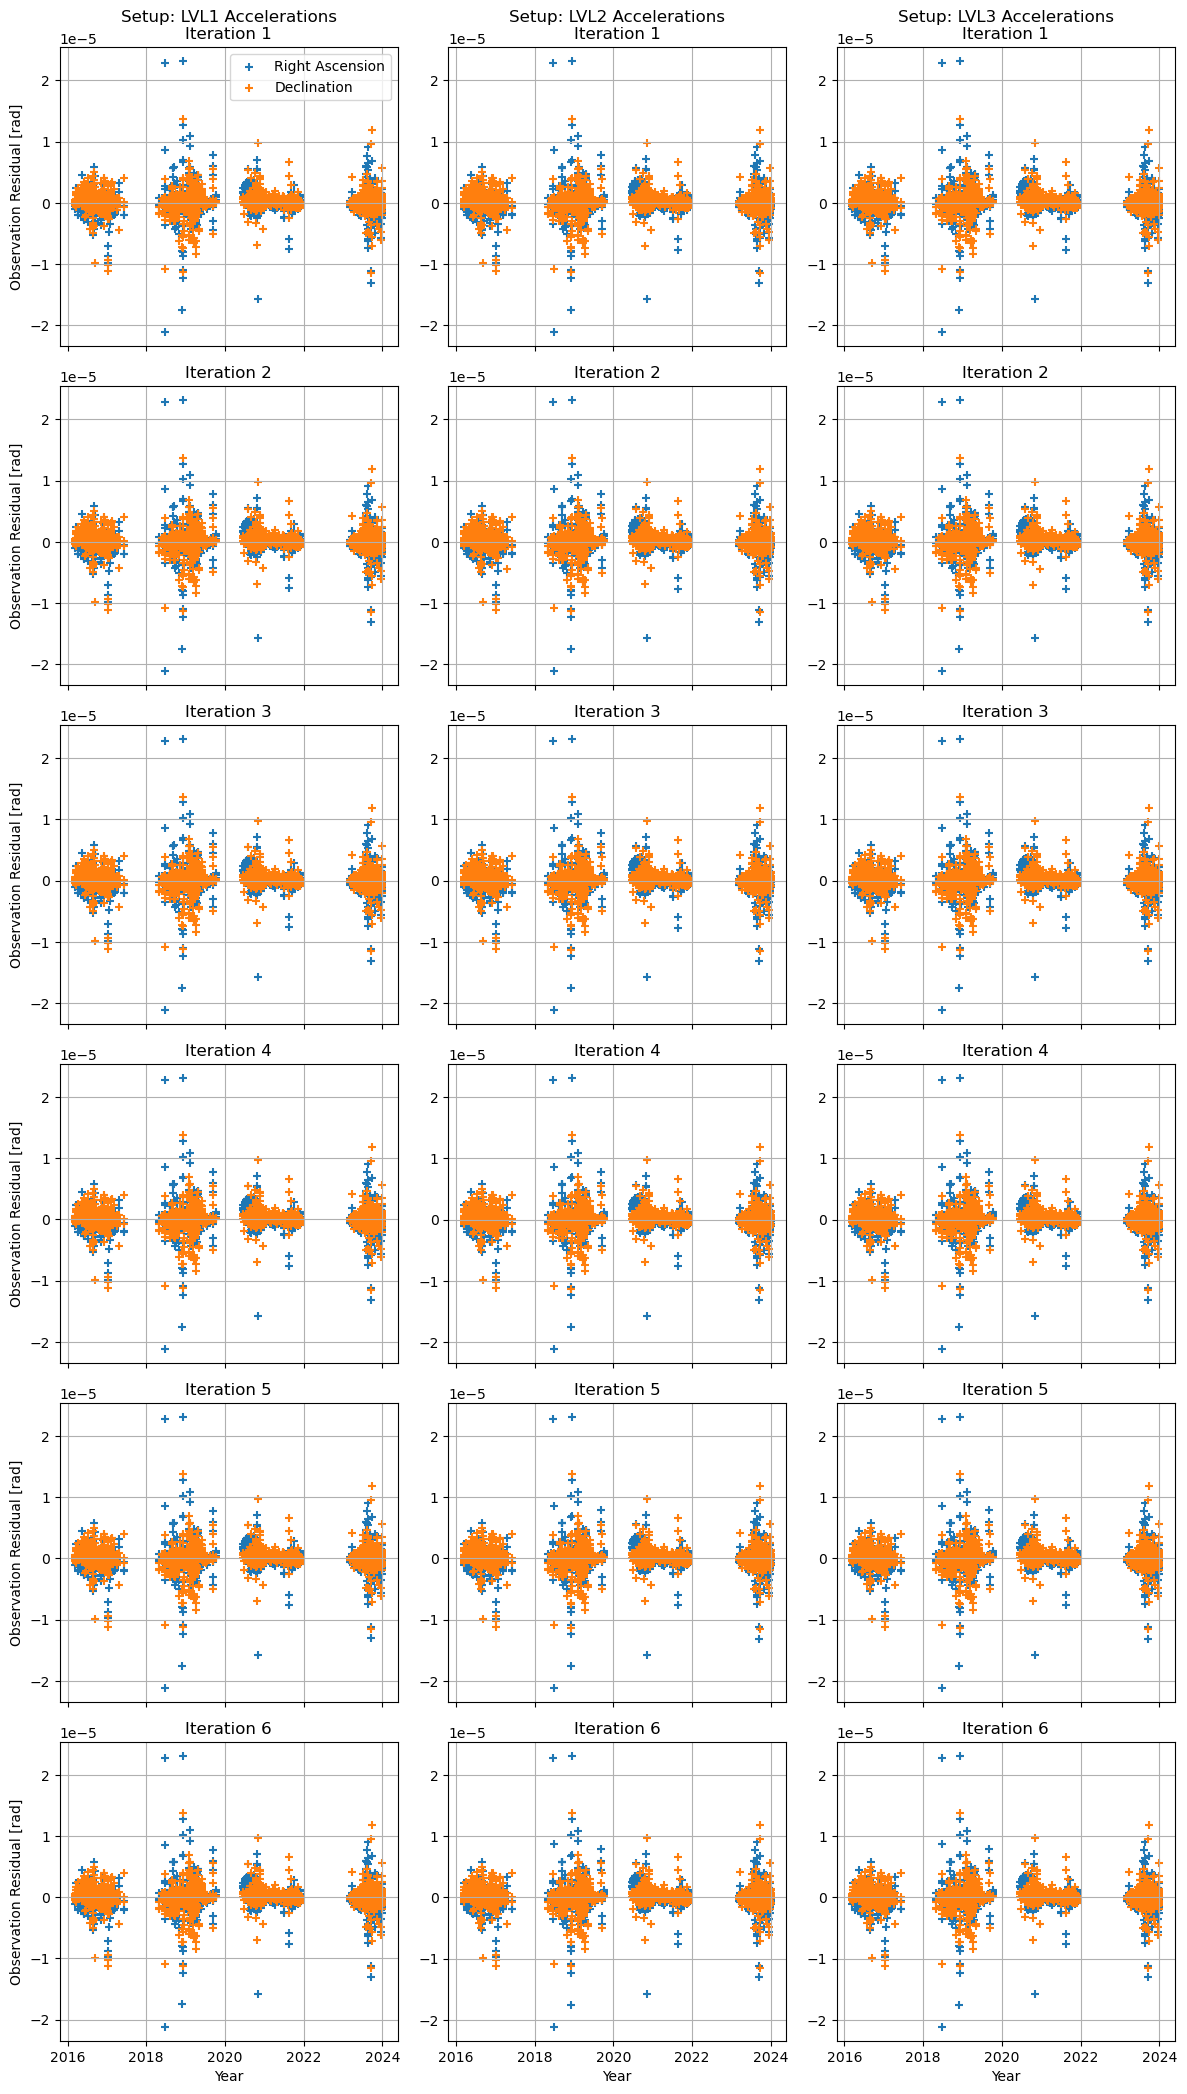

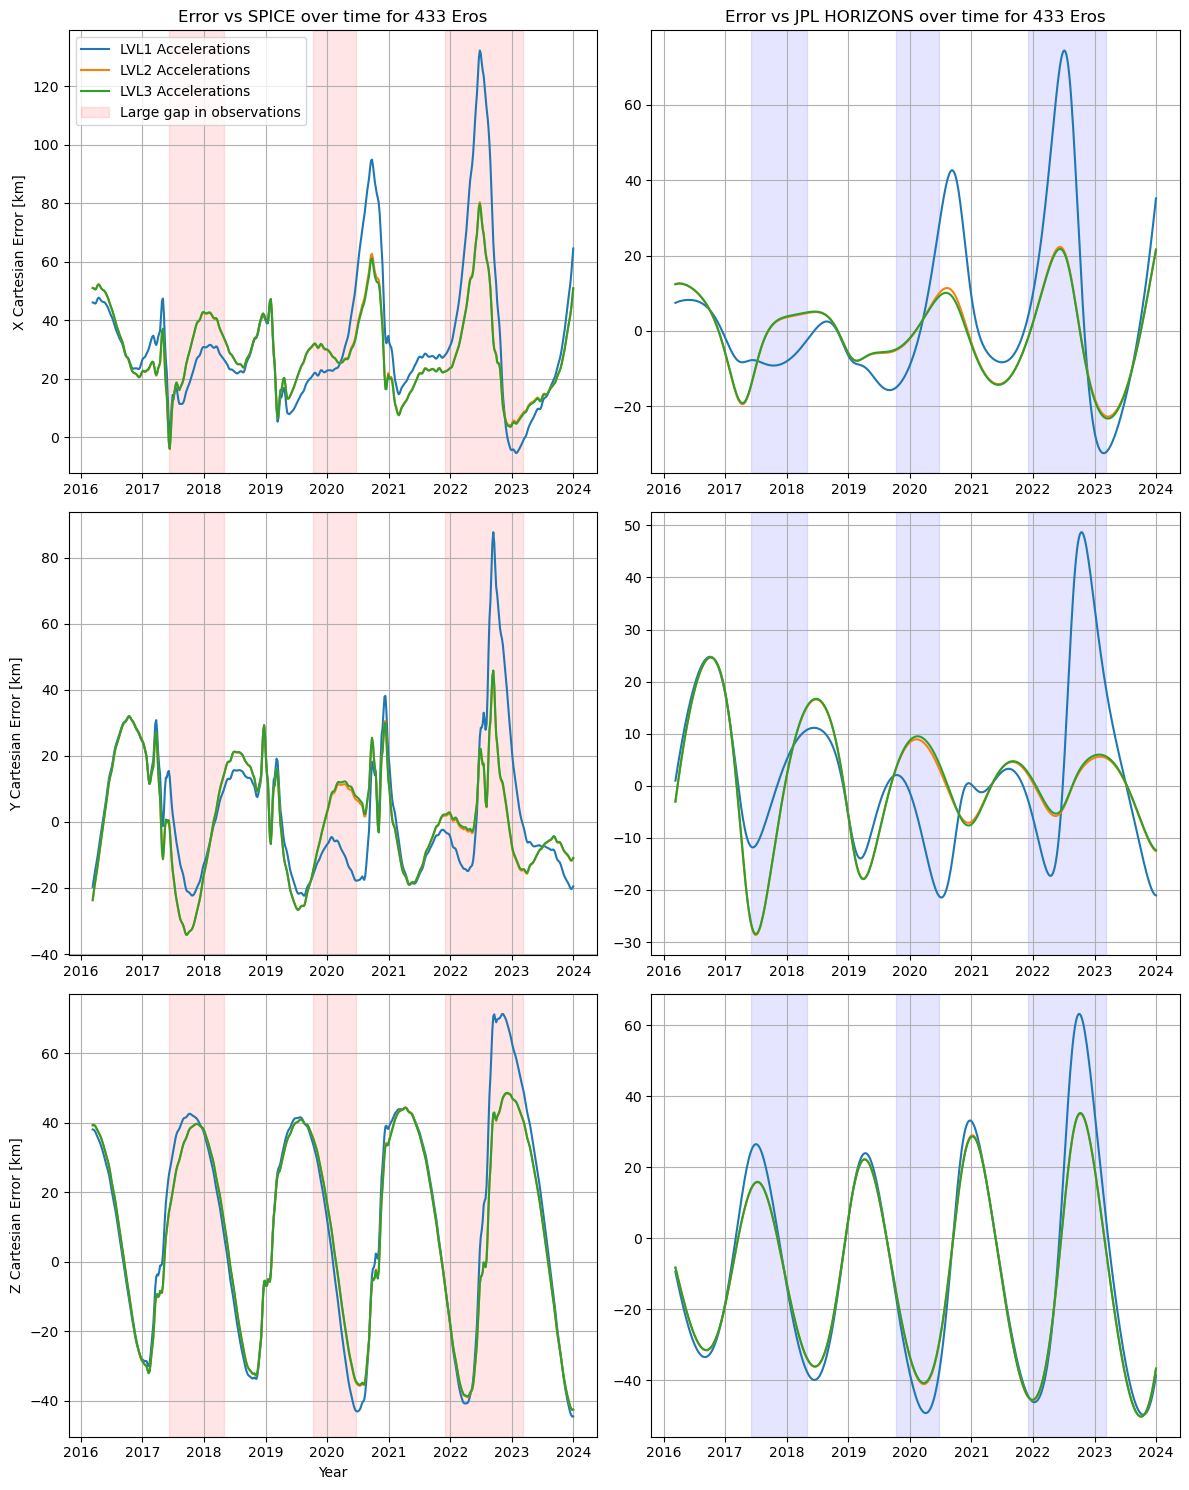

In [20]:
plot_residuals(setup_names, pod_output_set, observation_collection_set)
plot_cartesian(state_estimates_set, setup_names, observation_collection_set)

## Comparison Round 2: Weighting, Star Catalog Corrections and Satellite data

#### Weights and Star Catalog Biases
Before running the next round, lets have a quick look at the star catalog corrections and obsertvation weights which are based on the following literature:
- "Star catalog position and proper motion corrections in asteroid astrometry II: The Gaia era" by Eggl et al.
- "Statistical analysis of astrometric errors for the most productive asteroid surveys" by Veres et al.

Star catalogs are large databases of distant celestial objects (mainly stars) featuring details about their position, motion and other properties. Catalogs are used as reference when making observations of objects such as asteroids. Many different catalogs exist each with slightly varying contents and accuracy. The Gaia space telescope, launched in 2013, was designed specifically to measure celestial objects with unprecedented precision. The emergence of the resulting Gaia star catalogs (first appearing in 2016) has made all previous catalogs obsolete, however, observations made with older catalogs still contain their errors. These errors are corrected per observation by enabling the `apply_star_catalog_debias` option in `BatchMPC.to_tudat().

Additionally, not all observations have the same quality, to account for this we use weights to increase the effect of quality observations in our estimation. Specific observatories may have a higher accuracy, and individual observatories may improve their observation quality over time. Having too many observations by a single observatory in a short space of time may also introduce a heavy bias in the estimation. The work by Veres et al analyses the most prolific observatories to generate a weighting scheme which is enabled in Tudat using the `apply_star_catalog_debias` option in `BatchMPC.to_tudat()` and subsequently retrieving the weights in the pod_input using `pod_input.set_weights_from_observation_collection().
`

The plots below show star catalog corrections and observation weights for the observation period. Note in the star catalog correction graph how the number of corrections required (non-zero points) quickly reduces after 2016 once operators start implementing GAIA. Note also how a large clump of satellite observations in 2021 gets deweighted to prevent bias towards the satellite.

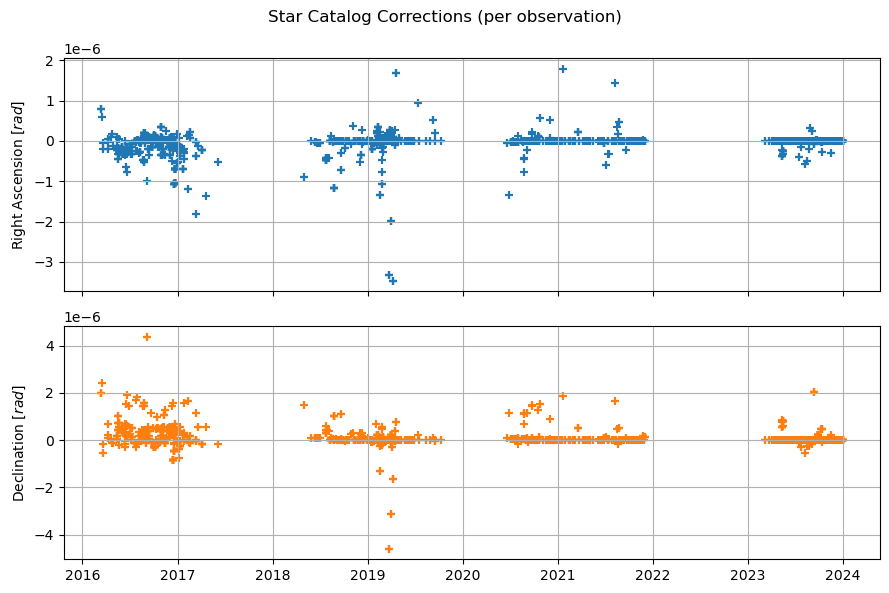

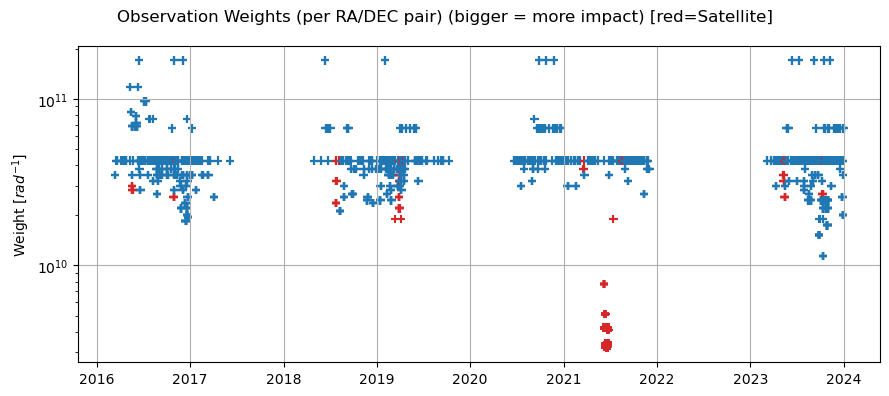

In [21]:
temp = batch.copy()
temp.to_tudat(bodies=bodies, included_satellites=None, apply_weights_VFCC17=True)
# mark weights red if it is a satellite observation
marker_color = ["tab:red" if x == "S" else "tab:blue" for x in temp.table.note2] 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
ax1.scatter(temp.table.epochUTC, temp.table.corr_RA_EFCC18, color="tab:blue", marker="+")
ax2.scatter(temp.table.epochUTC, temp.table.corr_DEC_EFCC18, color="tab:orange", marker="+")

ax1.set_ylabel(r"Right Ascension $[rad]$")
ax2.set_ylabel(r"Declination $[rad]$")
ax1.grid()
ax2.grid()
fig.suptitle("Star Catalog Corrections (per observation)")
fig.set_tight_layout(True)

fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.scatter(temp.table.epochUTC, temp.table.weight, marker="+", c=marker_color)
ax.set_yscale("log")
ax.set_ylabel(r"Weight $[rad^{-1}]$")
ax.grid()
fig.suptitle("Observation Weights (per RA/DEC pair) (bigger = more impact) [red=Satellite]")
fig.set_tight_layout(True)


#### Running the comparison
Lets now run some new setups with those features. As the difference between LVL2 and 3 accelerations is small, we use LVL 2 for all the remaining setups to save on runtime. Using level 2 as a baseline, we then succesively add the star catalog correction, observation weights and finally the satellite observations. The new estimation setups are defined below.


In [22]:
setup_names_2 = [
    "LVL2",
    "LVL2 + star catalog",
    "LVL2 + star catalog + weighting",
    "LVL2 + star catalog + weighting + Sat Data",
]

accel_levels_2 = [2, 2, 2, 2]
use_catalog_cor_2 = [False, True, True, True]
use_weighting_2 = [False, False, True, True]
use_sat_data_2 = [False, False, False, True]

In [23]:
pod_output_set_2 = []
batch_set_2 = []
observation_collection_set_2 = []
estimator_set_2 = []
state_estimates_set_2 = []

# This samples the cartesian state at 500 points over the observation time:
times_get_eph = np.linspace(epoch_start_nobuffer, epoch_end_nobuffer, 500)

for idx, setup_name in enumerate(setup_names_2):
    print(f"\n### Running setup #{idx+1} | {setup_name} ###")

    pod_output, batch, observation_collection, estimator = perform_estimation(
        bodies,
        acceleration_level=accel_levels_2[idx],
        use_satellite_data=use_sat_data_2[idx],
        apply_star_catalog_debias=use_catalog_cor_2[idx],
        apply_weighting_scheme=use_weighting_2[idx],
    )
    state_estimates = []
    for timee in times_get_eph:
        state_est = bodies.get(str(target_mpc_code)).ephemeris.cartesian_state(timee)
        state_estimates.append(state_est)

    pod_output_set_2.append(pod_output)
    batch_set_2.append(batch)
    observation_collection_set_2.append(observation_collection)
    estimator_set_2.append(estimator)
    state_estimates_set_2.append(state_estimates)


### Running setup #1 | LVL2 ###
Calculating residuals and partials 6094
Current residual: 2.14653e-06
Parameter update     -39670     42322.4    -34795.9   -0.003954 -0.00236926  -0.0015788
Calculating residuals and partials 6094
Current residual: 1.54598e-06
Parameter update     0.34351    0.0693748    -0.252655  1.84115e-08  1.52518e-08 -1.73916e-08
Calculating residuals and partials 6094
Current residual: 1.54598e-06
Parameter update   0.014412  -0.0215233  -0.0102281 7.36792e-10 2.37781e-09 1.38206e-09
Calculating residuals and partials 6094
Current residual: 1.54598e-06
Parameter update  -0.0104136    0.0147806     0.006137 -6.15402e-10    -1.49e-09 -9.73724e-10
Calculating residuals and partials 6094
Current residual: 1.54598e-06
Parameter update  0.00231725 -0.000686117  7.24252e-05  2.27573e-10 -1.05001e-10  1.12545e-10
Calculating residuals and partials 6094
Current residual: 1.54598e-06
Maximum number of iterations reached
Parameter update -0.00671528   0.00339387  0.0004770

#### The results
Before looking at the plots, lets look at the formal errors. We can see that the formal errors are reduced when the weights are applied, indicating that it is working.


In [28]:
for name, p_out in zip(setup_names_2, pod_output_set_2):
    print(name, " | ", list(p_out.formal_errors))

LVL2  |  [7142972639.555403, 5831342133.805652, 3633222800.3392677, 425.8726626207447, 571.7770233323795, 412.8539065873022]
LVL2 + star catalog  |  [7142972584.245723, 5831342092.938162, 3633222830.2632856, 425.87268104400204, 571.7770123730025, 412.85386564862586]
LVL2 + star catalog + weighting  |  [34799.27387629024, 28873.695879317314, 18520.798460387796, 0.0020515771329109025, 0.0028079925288120766, 0.002022392366710594]
LVL2 + star catalog + weighting + Sat Data  |  [34086.84188484646, 28235.193615051558, 18188.391062986422, 0.002024966314678562, 0.002752470495456678, 0.001982989891042987]


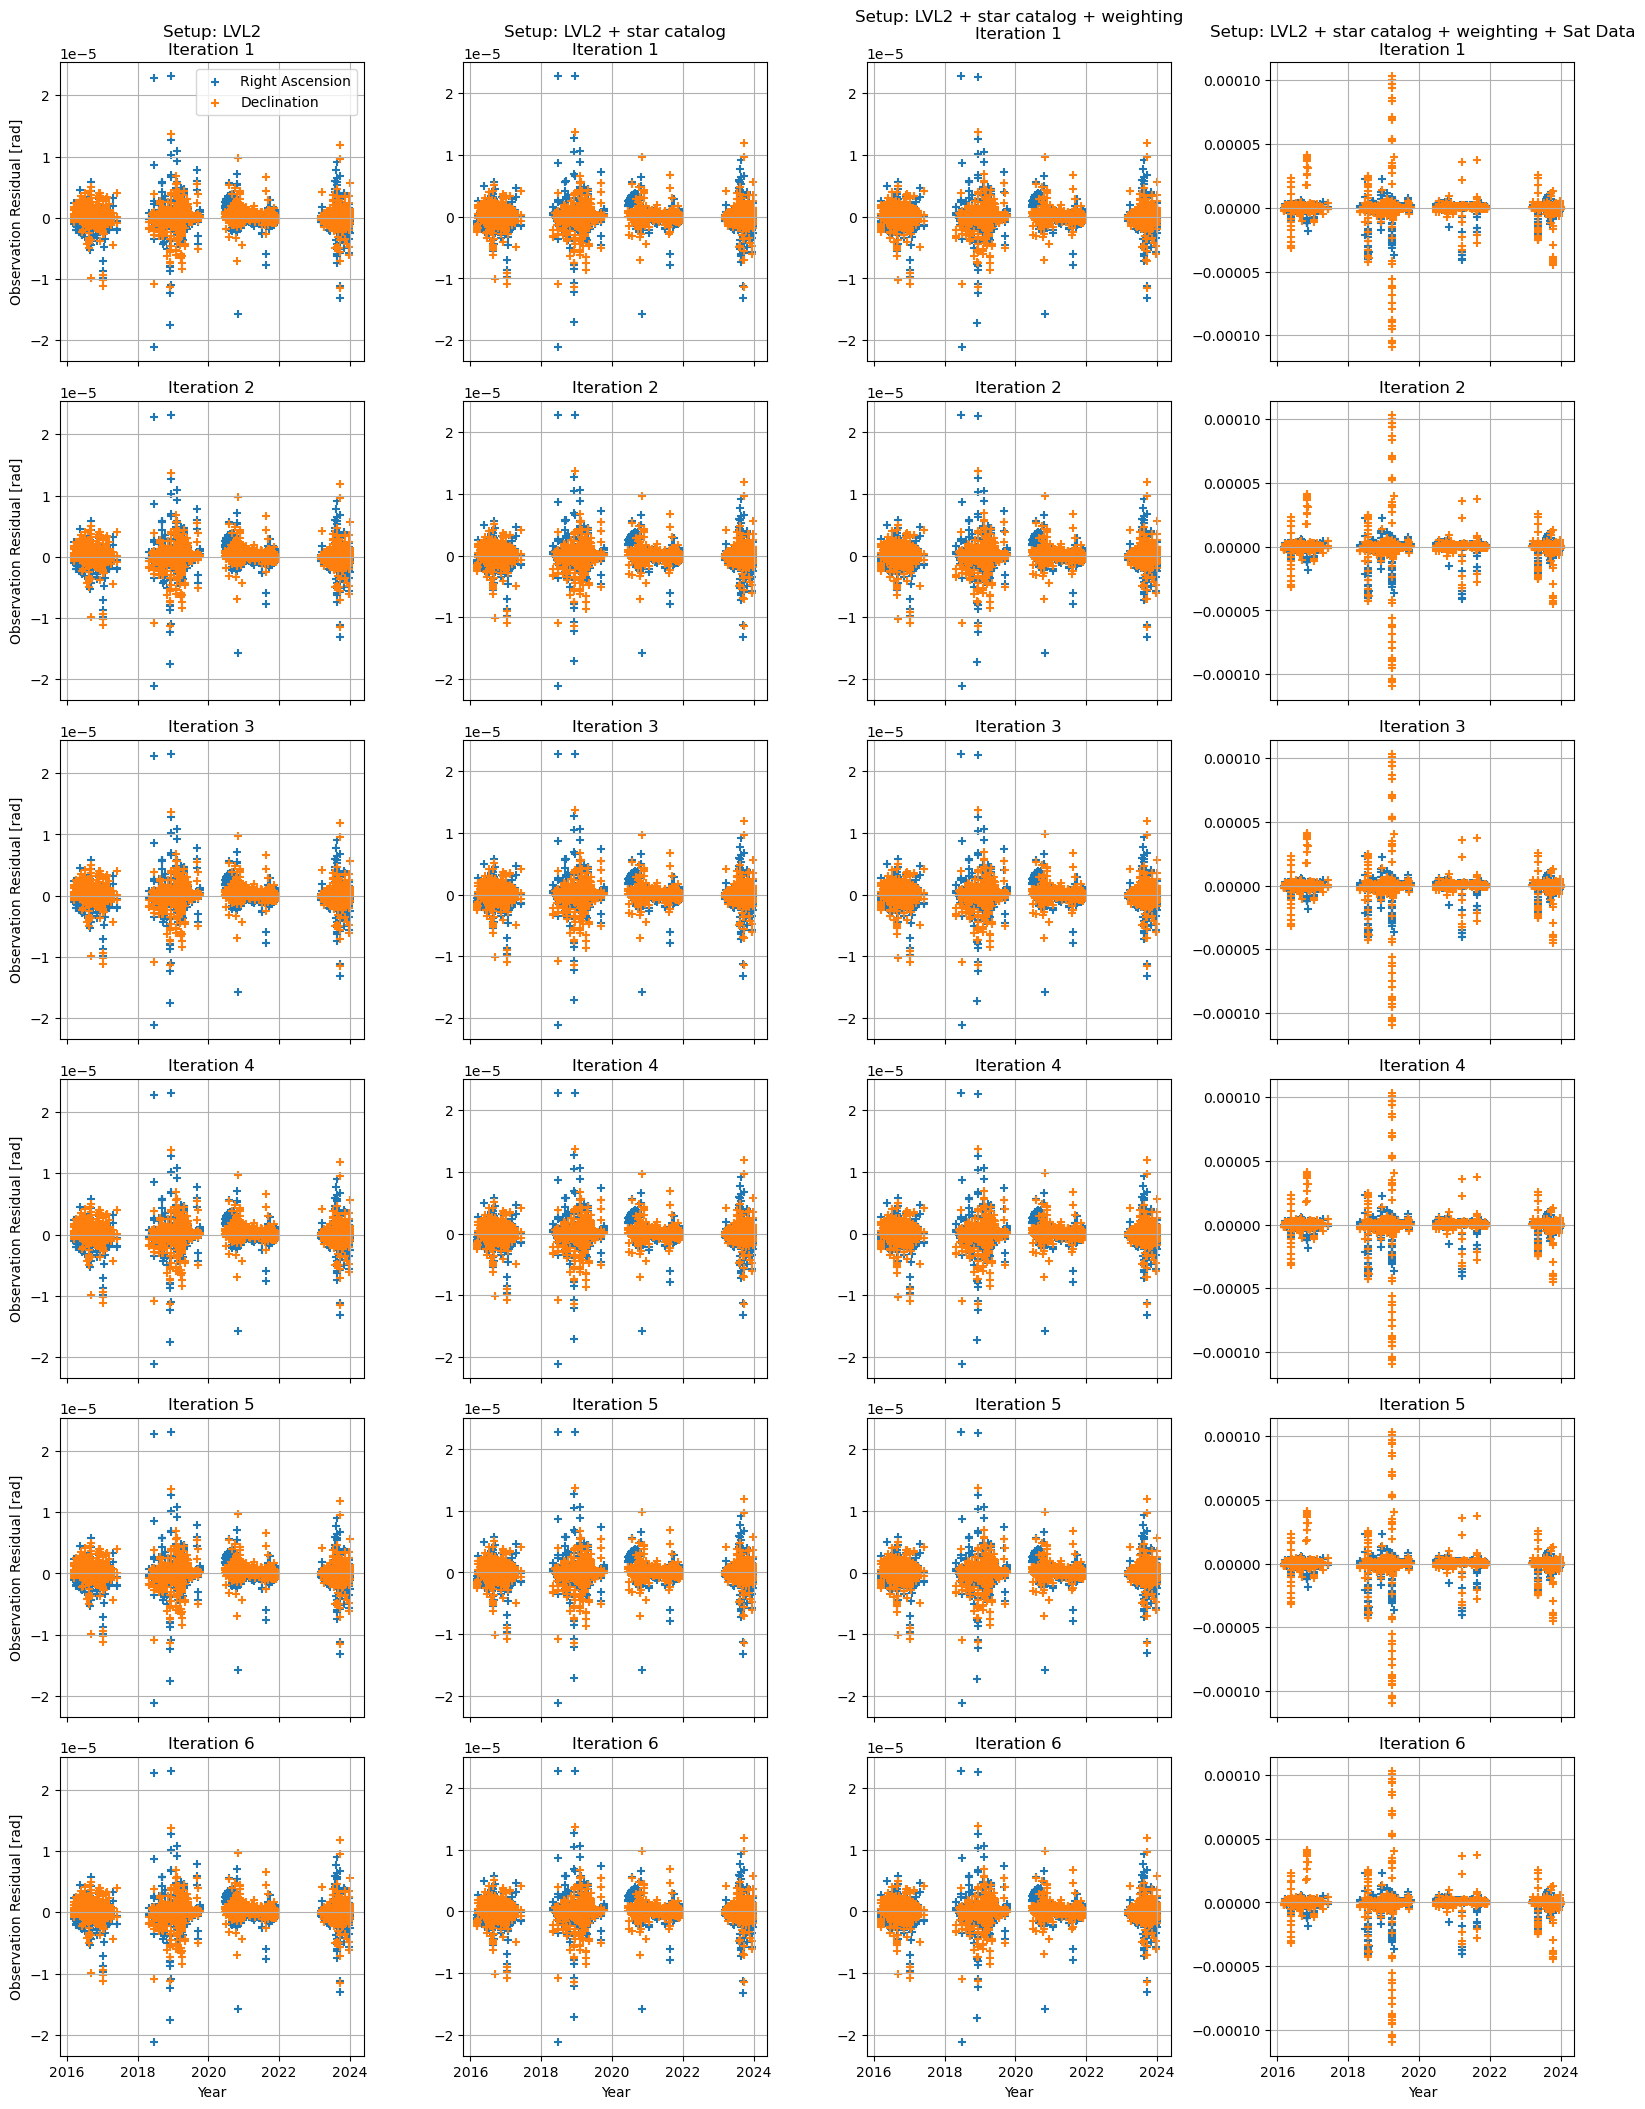

In [24]:
plot_residuals(setup_names_2, pod_output_set_2, observation_collection_set_2)
plot_cartesian(state_estimates_set_2, setup_names_2, observation_collection_set_2)

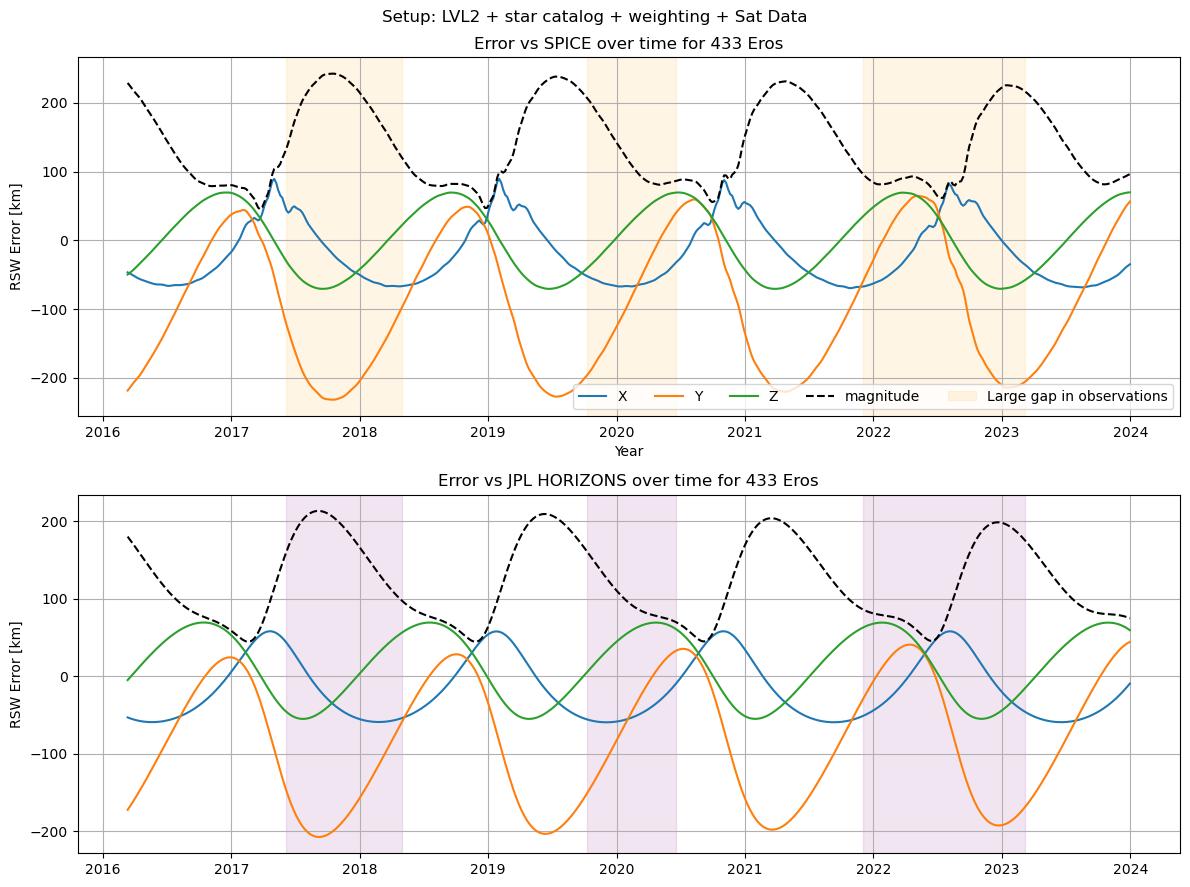

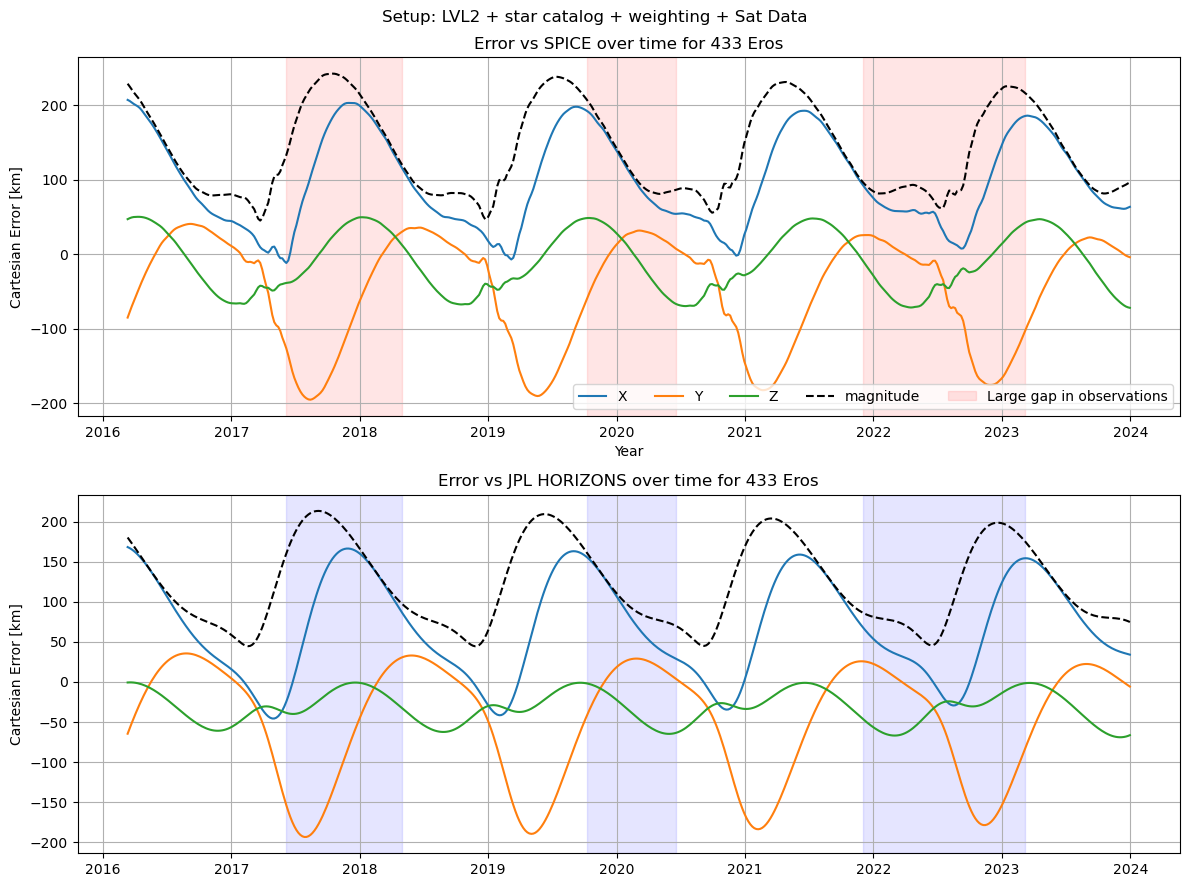

In [26]:
plot_cartesian_single(state_estimates_set_2[3], setup_names_2[3], observation_collection_set_2[3], in_RSW_frame=True)
plot_cartesian_single(state_estimates_set_2[3], setup_names_2[3], observation_collection_set_2[3], in_RSW_frame=False)
# plot_cartesian_single(state_estimates_set_2[0], setup_names_2[0], observation_collection_set_2[0])

NameError: name 'p_out_set2' is not defined

ADD MORE PLOTS FOR THE FINAL CHOSEN VERSION